In [2]:
import numpy as np
import gzip
import pickle
import sys
import copy
import os.path
import pdb
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from run_split import SplitMnistGenerator, SplitMnistRandomGenerator, SplitMnistBackgroundGenerator
from alg.cla_models_multihead import MFVI_IBP_NN, Vanilla_NN
from alg.utils import get_uncertainties, get_scores, concatenate_results
import tensorflow as tf

W1103 16:35:38.766226 139814004037440 deprecation_wrapper.py:119] From alg/cla_models_multihead.py:9: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



# Permuted MNIST

In [2]:
# permuted_mnist_res5_perm.pkl
with open('results/permuted_mnist_res5_perm.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'Z'])

In [5]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

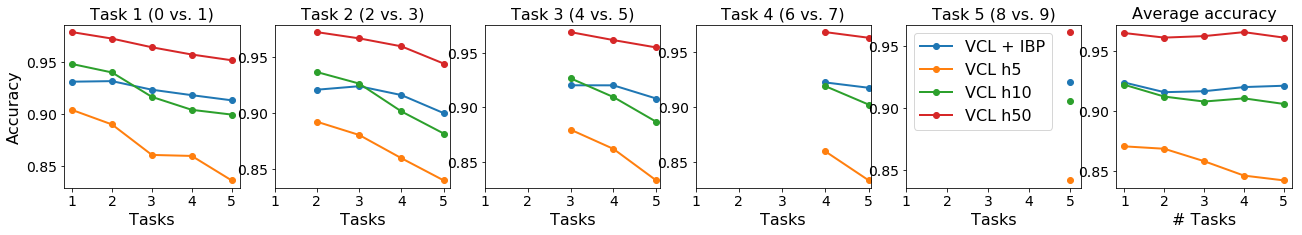

In [6]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(_ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(_vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(_vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(_vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
plt.savefig("plots/perm_mnist_all.pdf", bbox_inches='tight')
fig.show()

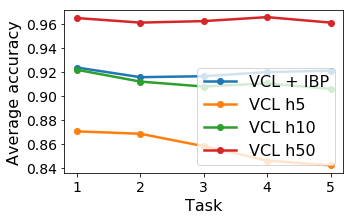

In [8]:
lw=2.5
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
plt.plot(np.arange(len(__vcl_result_h5))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
plt.plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
plt.plot(np.arange(len(__vcl_result_h50))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy', fontsize=legend_size)
ax.set_xlabel('Task', fontsize=legend_size)
ax.legend(fontsize=legend_size, loc='lower right')
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.savefig("plots/perm_mnist.pdf", bbox_inches='tight')
fig.show()

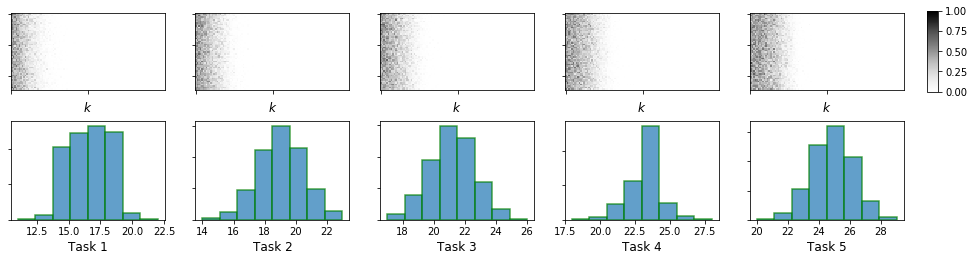

In [9]:
Zs = d['Z']
lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 16
tick_size = 12
legend_size = 12

num_tasks = 5
fig, ax = plt.subplots(2, num_tasks, figsize=(16, 4))
for i in range(num_tasks):
    imgplot = ax[0][i].imshow(np.squeeze(Zs[i])[:50,:], cmap=plt.cm.Greys, vmin=0, vmax=1)
    ax[0][i].set_xticks(np.arange(0.0, 100, step=50))
    ax[0][i].set_xticklabels([],fontsize=tick_size)
    ax[0][i].set_yticklabels([], [])
    ax[0][i].set_xlabel('$k$', fontsize=legend_size)
    #ax[1][i].hist(np.sum(np.squeeze(Zs[i]), axis=1), 16, alpha=0.7, edgecolor='green', linewidth=1.5)
    ax[1][i].hist(np.sum(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int), axis=1), 8, alpha=0.7, edgecolor='green',
                 linewidth=1.5)
    ax[1][i].set_yticklabels([], [])
    ax[1][i].set_xlabel("Task {}".format(i+1), fontsize=legend_size)
    if i == 4:
        cbar_ax = fig.add_axes([0.92, 0.57, 0.01, 0.28])
        fig.colorbar(imgplot, cax=cbar_ax)
#plt.savefig('plots/Zs_{0}.pdf'.format(tag), bbox_inches='tight')
plt.show()

In [10]:
print("Permuted MNIST")
[np.mean(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int)) for i in range(num_tasks)]

Permuted MNIST


[0.166092, 0.190082, 0.212106, 0.230395, 0.248259]

# New results Normal MNIST

In [66]:
with open('results/split_mnist_res5_split_normal.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [67]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


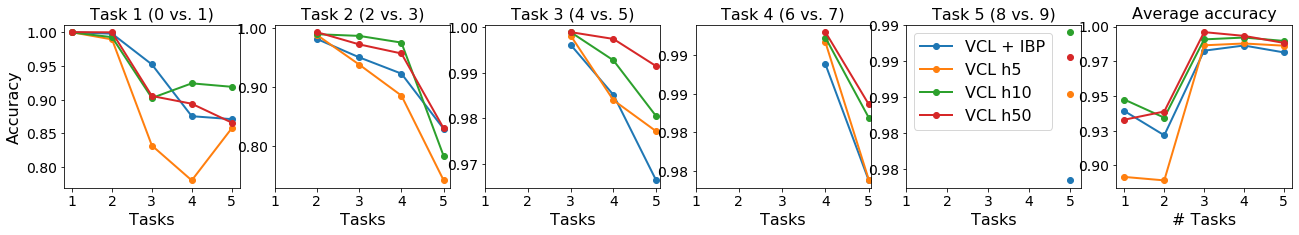

In [68]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].tick_params(labelsize=tick_size)
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax[5].legend()
plt.savefig("plots/split_normal_all.pdf", bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


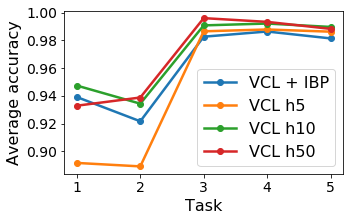

In [69]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

lw=2.5
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy', fontsize=legend_size)
ax.set_xlabel('Task', fontsize=legend_size)
ax.legend(fontsize=legend_size, loc='lower right')
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.savefig("plots/split_normal.pdf", bbox_inches='tight')
fig.show()

# Random background noise MNIST

In [62]:
with open('results/split_mnist_res5_split_random.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [63]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


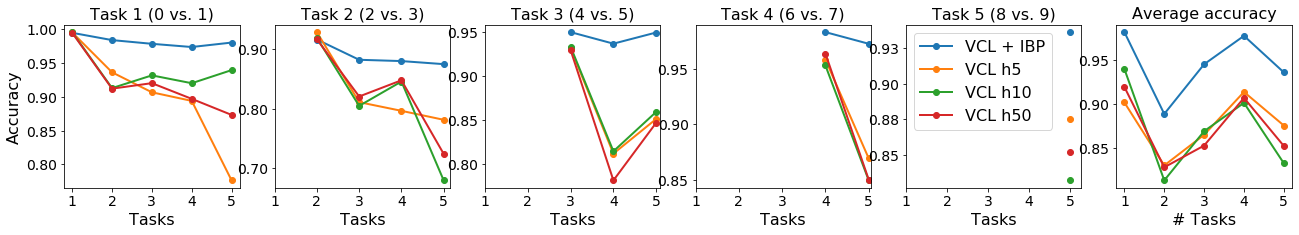

In [64]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig("plots/rand_background_noise_all.pdf", bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


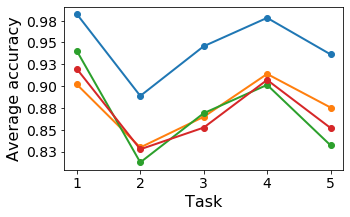

In [65]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy', fontsize=legend_size)
ax.set_xlabel('Task', fontsize=legend_size)
#ax.legend(fontsize=legend_size, loc='lower right')
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig("plots/rand_background_noise.pdf", bbox_inches='tight')
fig.show()

# Background images MNIST

In [57]:
#split_mnist_res5_split_background.pkl
with open('results/split_mnist_res5_split_background.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [58]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


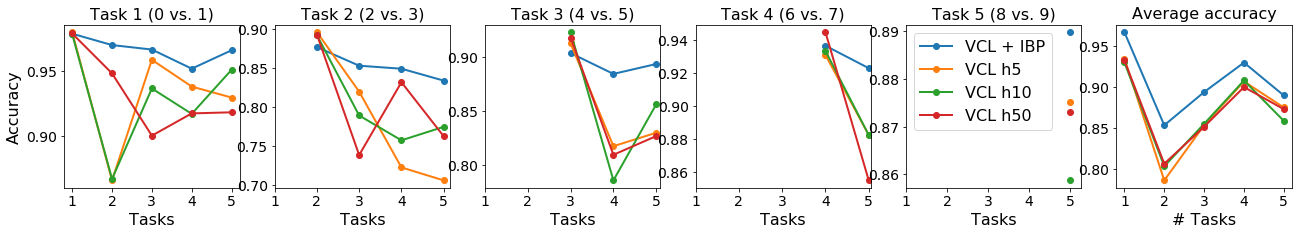

In [59]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig("plots/image_background_noise_all.pdf", bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


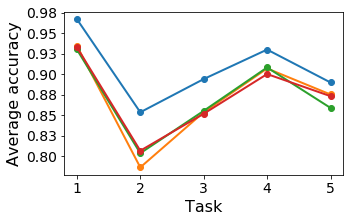

In [61]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy', fontsize=legend_size)
ax.set_xlabel('Task', fontsize=legend_size)
#ax.legend(fontsize=legend_size, loc='lower right')
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig("plots/image_background_noise.pdf", bbox_inches='tight')
fig.show()

# Not MNIST

In [80]:
#split_mnist_res5_split_background.pkl
with open('../results/split_not_mnist_res5_split_not_new.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'Z'])

In [81]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


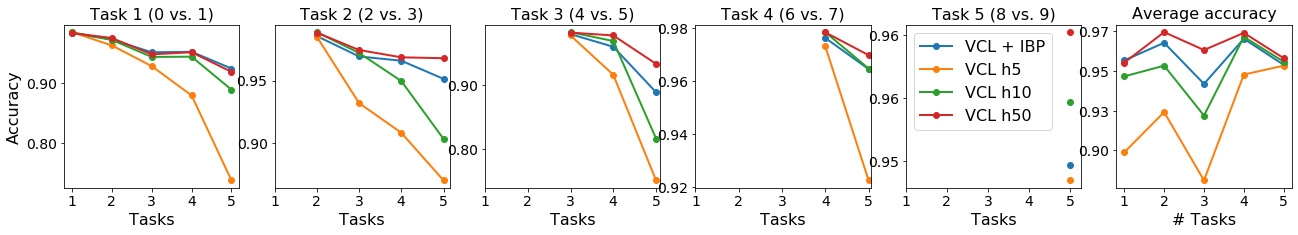

In [82]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig("plots/not_all_accs.pdf", bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


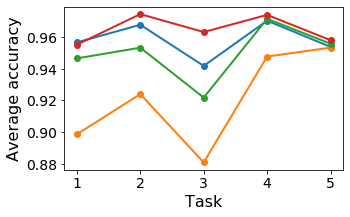

In [56]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o', linewidth=lw)
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy', fontsize=legend_size)
ax.set_xlabel('Task', fontsize=legend_size)
#ax.legend(fontsize=legend_size, loc='lower right')
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig("plots/not_av_acc.pdf", bbox_inches='tight')
fig.show()

# Not MNIST + noise

In [84]:
with open('results/split_not_mnist_res5_split_not_noise_new.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'Z'])

In [85]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


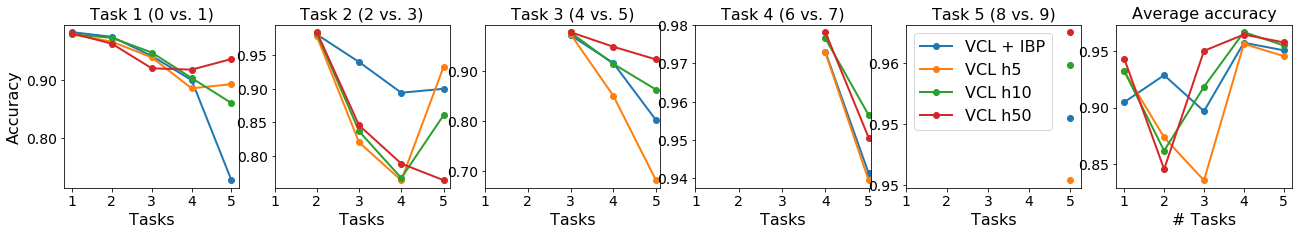

In [86]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig("plots/not_noise_all_accs.pdf", bbox_inches='tight')
fig.show()

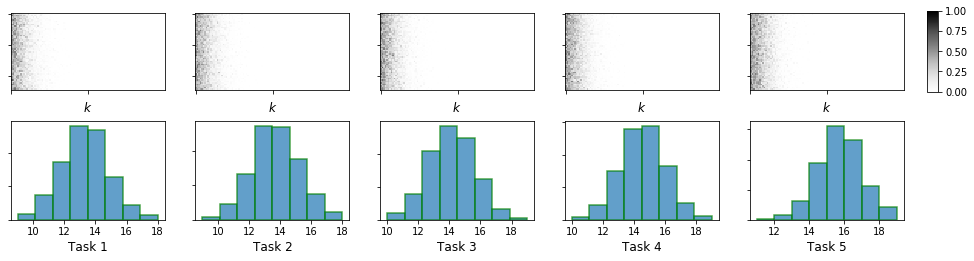

In [101]:
Zs = d['Z']
lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 16
tick_size = 12
legend_size = 12

num_tasks = 5
fig, ax = plt.subplots(2, num_tasks, figsize=(16, 4))
for i in range(num_tasks):
    imgplot = ax[0][i].imshow(np.squeeze(Zs[i])[:50,:], cmap=plt.cm.Greys, vmin=0, vmax=1)
    ax[0][i].set_xticks(np.arange(0.0, 100, step=50))
    ax[0][i].set_xticklabels([],fontsize=tick_size)
    ax[0][i].set_yticklabels([], [])
    ax[0][i].set_xlabel('$k$', fontsize=legend_size)
    #ax[1][i].hist(np.sum(np.squeeze(Zs[i]), axis=1), 16, alpha=0.7, edgecolor='green', linewidth=1.5)
    ax[1][i].hist(np.sum(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int), axis=1), 8, alpha=0.7, edgecolor='green',
                 linewidth=1.5)
    ax[1][i].set_yticklabels([], [])
    ax[1][i].set_xlabel("Task {}".format(i+1), fontsize=legend_size)
    if i == 4:
        cbar_ax = fig.add_axes([0.92, 0.57, 0.01, 0.28])
        fig.colorbar(imgplot, cax=cbar_ax)
#plt.savefig('plots/Zs_{0}.pdf'.format(tag), bbox_inches='tight')
plt.show()

In [102]:
#np.where(np.squeeze(Zs[i])
[np.mean(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int)) for i in range(num_tasks)]

[0.041719723, 0.042865794, 0.0449421, 0.046520226, 0.049147744]

# Z histograms

In [19]:
dataset='random' #'normal' # background, random
tag='split_random_new' # split_normal_new split_background_new, split_random_new
val = False
def get_datagen():
    if dataset == 'normal':
        data_gen = SplitMnistGenerator(val=val, difficult=False)
    elif dataset == 'random':
        data_gen = SplitMnistRandomGenerator(val=val)
    elif dataset == 'background':
        data_gen = SplitMnistBackgroundGenerator(val=val)
    else:
        raise ValueError('Pick dataset in {normal, random, background}')
    return data_gen

############
## Params ##
############
data_gen = get_datagen()
in_dim, out_dim = data_gen.get_dims()
alpha0 = 5.0
beta0 = 1.0
lambda_1 = 1.0
lambda_2 = 1.0
hidden_size = [100]
bsize = 256
no_epochs = 1000
ibp_samples = 10
coreset_size = 0
single_head = False
in_dim = 28 * 28
out_dim = 2
run=0
name='ibp_split_mnist_{2}_run{0}_{1}'.format(run+1, tag, dataset)

################################################
## Restore model for each task and get test Z ##
################################################
Zs = []
x_testsets, y_testsets = [], []
for task_id in range(data_gen.max_iter):
    tf.reset_default_graph()
    x_train, y_train, x_test, y_test = data_gen.next_task()
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 100, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    #x_testsets.append(x_test)
    #y_testsets.append(y_test)
    
    name='ibp_split_mnist_{2}_run{0}_{1}'.format(run+1, tag, dataset)
    log_folder = os.path.join('logs', "graph_{}_task{}".format(name, task_id))
    mf_model = MFVI_IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=None,
                           prev_log_variances=None, prev_betas=None,
                           alpha0=alpha0, beta0=beta0, learning_rate=0.0001,
                           lambda_1=lambda_1,
                           lambda_2=lambda_2 if task_id == 0 else lambda_1,
                           no_pred_samples=100,
                           name=name)
    mf_model.restore(log_folder)
    
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()
    
    Zs.append(mf_model.sess.run(mf_model.Z, feed_dict={mf_model.x: x_test,
                                                       mf_model.task_idx: task_id,
                                                       mf_model.training: False, mf_model.temp: 1.0})[0])

    mf_model.close_session()

Epoch: 0001 cost= 0.342618288
Epoch: 0006 cost= 0.014021522
Epoch: 0011 cost= 0.006624316
Epoch: 0016 cost= 0.003416701
Epoch: 0021 cost= 0.001510022
Epoch: 0026 cost= 0.000940980
Epoch: 0031 cost= 0.000608209
Epoch: 0036 cost= 0.000448573
Epoch: 0041 cost= 0.000356163
Epoch: 0046 cost= 0.000255134
Epoch: 0051 cost= 0.000208673
Epoch: 0056 cost= 0.000158520
Epoch: 0061 cost= 0.000129000
Epoch: 0066 cost= 0.000106386
Epoch: 0071 cost= 0.000087653
Epoch: 0076 cost= 0.000071451
Epoch: 0081 cost= 0.000060583
Epoch: 0086 cost= 0.000053567
Epoch: 0091 cost= 0.000043578
Epoch: 0096 cost= 0.000037543
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_ibp_split_mnist_random_run1_split_random_new_task0/model.ckpt
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_ibp_split_mnist_random_run1_split_random_new_task1/model.ckpt
(1, ?,

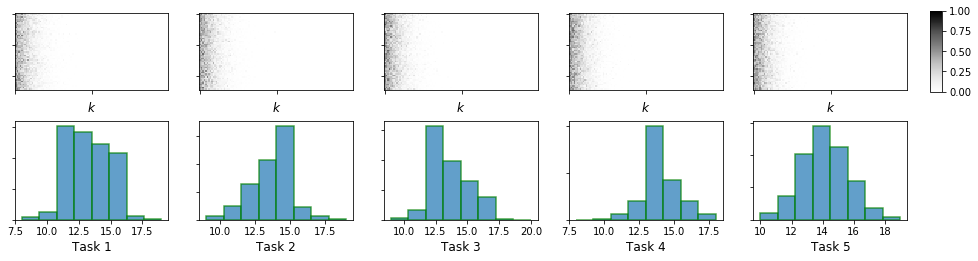

In [21]:
lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 16
tick_size = 12
legend_size = 12

num_tasks = 5
fig, ax = plt.subplots(2, num_tasks, figsize=(16, 4))
for i in range(num_tasks):
    imgplot = ax[0][i].imshow(np.squeeze(Zs[i])[:50,:], cmap=plt.cm.Greys, vmin=0, vmax=1)
    ax[0][i].set_xticks(np.arange(0.0, 100, step=50))
    ax[0][i].set_xticklabels([],fontsize=tick_size)
    ax[0][i].set_yticklabels([], [])
    ax[0][i].set_xlabel('$k$', fontsize=legend_size)
    #ax[1][i].hist(np.sum(np.squeeze(Zs[i]), axis=1), 16, alpha=0.7, edgecolor='green', linewidth=1.5)
    ax[1][i].hist(np.sum(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int), axis=1), 8, alpha=0.7, edgecolor='green',
                 linewidth=1.5)
    ax[1][i].set_yticklabels([], [])
    ax[1][i].set_xlabel("Task {}".format(i+1), fontsize=legend_size)
    if i == 4:
        cbar_ax = fig.add_axes([0.92, 0.57, 0.01, 0.28])
        fig.colorbar(imgplot, cax=cbar_ax)
plt.savefig('plots/Zs_{0}_cutoff_{1}.pdf'.format(tag, 0.1), bbox_inches='tight')
plt.show()

In [13]:
print(tag)
[np.mean(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int)) for i in range(num_tasks)]

split_normal_new


[0.13220330969267138,
 0.1343388834476004,
 0.13632337246531484,
 0.13690835850956698,
 0.13896116994452848]

In [18]:
print(tag)
[np.mean(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int)) for i in range(num_tasks)]

split_background_new


[0.13353245531514582,
 0.13438057482656096,
 0.13672852598091198,
 0.1388938492063492,
 0.13956499488229274]

In [22]:
print(tag)
[np.mean(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int)) for i in range(num_tasks)]

split_random_new


[0.1325812356979405,
 0.13480673934588702,
 0.13694591728525982,
 0.13964230965763924,
 0.14206243602865917]

## Not MNIST

In [23]:
# split_not_mnist_res5_split_not_new.pkl
with open('results/split_not_mnist_res5_split_not_new.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'Z'])

In [24]:
Zs = d['Z']

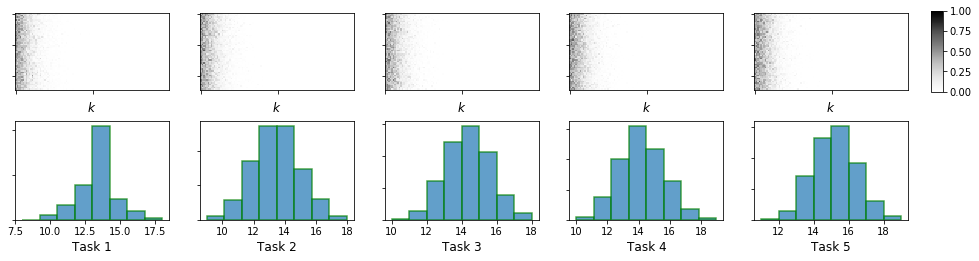

In [25]:
tag='not'
lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 16
tick_size = 12
legend_size = 12

num_tasks = 5
fig, ax = plt.subplots(2, num_tasks, figsize=(16, 4))
for i in range(num_tasks):
    imgplot = ax[0][i].imshow(np.squeeze(Zs[i])[:50,:], cmap=plt.cm.Greys, vmin=0, vmax=1)
    ax[0][i].set_xticks(np.arange(0.0, 100, step=50))
    ax[0][i].set_xticklabels([],fontsize=tick_size)
    ax[0][i].set_yticklabels([], [])
    ax[0][i].set_xlabel('$k$', fontsize=legend_size)
    #ax[1][i].hist(np.sum(np.squeeze(Zs[i]), axis=1), 16, alpha=0.7, edgecolor='green', linewidth=1.5)
    ax[1][i].hist(np.sum(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int), axis=1), 8, alpha=0.7, edgecolor='green',
                 linewidth=1.5)
    ax[1][i].set_yticklabels([], [])
    ax[1][i].set_xlabel("Task {}".format(i+1), fontsize=legend_size)
    if i == 4:
        cbar_ax = fig.add_axes([0.92, 0.57, 0.01, 0.28])
        fig.colorbar(imgplot, cax=cbar_ax)
plt.savefig('plots/Zs_{0}_cutoff_{1}.pdf'.format(tag, 0.1), bbox_inches='tight')
plt.show()

In [26]:
print(tag)
[np.mean(np.asarray(np.squeeze(Zs[i] > 0.1)).astype(int)) for i in range(num_tasks)]

not


[0.132345, 0.134795, 0.138395, 0.14234, 0.14691]

# Uncertainty

In [9]:
dataset='random' #'normal' # background, random
tag='split_random_new' # split_normal_new split_background_new, split_random_new
val = False
def get_datagen():
    if dataset == 'normal':
        data_gen = SplitMnistGenerator(val=val, difficult=False)
    elif dataset == 'random':
        data_gen = SplitMnistRandomGenerator(val=val)
    elif dataset == 'background':
        data_gen = SplitMnistBackgroundGenerator(val=val)
    else:
        raise ValueError('Pick dataset in {normal, random, background}')
    return data_gen

############
## Params ##
############
data_gen = get_datagen()
in_dim, out_dim = data_gen.get_dims()
alpha0 = 5.0
beta0 = 1.0
lambda_1 = 1.0
lambda_2 = 1.0
hidden_size = [100]
bsize = 256
no_epochs = 1000
ibp_samples = 10
coreset_size = 0
single_head = False
in_dim = 28 * 28
out_dim = 2
run=0
name='ibp_split_mnist_{2}_run{0}_{1}'.format(run+1, tag, dataset)

# get all test sets for uncertainty quantification
x_testsets, y_testsets = [], []
for _ in range(data_gen.max_iter):
    if val:
        _, _, x_test, y_test, _, _ = data_gen.next_task()
    else:
        _, _, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

# re-initialise
data_gen = get_datagen()

Zs = []
all_uncerts = np.zeros((data_gen.max_iter, data_gen.max_iter))
for task_id in range(data_gen.max_iter):
    tf.reset_default_graph()
    
    # get all test sets for uncertainty quantification
    if val:
        x_train, y_train, _, _, _, _ = data_gen.next_task()
    else:
        x_train, y_train, _, _ = data_gen.next_task()
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 100, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()
    
    name='ibp_split_mnist_{2}_run{0}_{1}'.format(run+1, tag, dataset)
    log_folder = os.path.join('logs', "graph_{}_task{}".format(name, task_id))
    mf_model = MFVI_IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights,
                           prev_log_variances=mf_variances, prev_betas=mf_betas,
                           alpha0=alpha0, beta0=beta0, learning_rate=0.0001,
                           lambda_1=lambda_1,
                           lambda_2=lambda_2 if task_id == 0 else lambda_1,
                           no_pred_samples=100,
                           name=name)
    mf_model.restore(log_folder)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()
    all_uncerts[task_id, :] = get_uncertainties(mf_model, x_testsets, y_testsets, single_head, task_id)
    mf_model.close_session()

Epoch: 0001 cost= 0.361013524
Epoch: 0006 cost= 0.012471653
Epoch: 0011 cost= 0.005444872
Epoch: 0016 cost= 0.002264623
Epoch: 0021 cost= 0.001267201
Epoch: 0026 cost= 0.000884049
Epoch: 0031 cost= 0.000561274
Epoch: 0036 cost= 0.000422726
Epoch: 0041 cost= 0.000323949
Epoch: 0046 cost= 0.000237851
Epoch: 0051 cost= 0.000189181
Epoch: 0056 cost= 0.000154691
Epoch: 0061 cost= 0.000120213
Epoch: 0066 cost= 0.000100024
Epoch: 0071 cost= 0.000082185
Epoch: 0076 cost= 0.000070631
Epoch: 0081 cost= 0.000058281
Epoch: 0086 cost= 0.000050174
Epoch: 0091 cost= 0.000041442
Epoch: 0096 cost= 0.000037193
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_ibp_split_mnist_random_run1_split_random_new_task0/model.ckpt
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_ibp_split_mnist_random_run1_split_random_new_task1/model.ckpt
(1, ?,

# Split

In [4]:
all_uncerts_norm = all_uncerts / np.tile(np.max(all_uncerts, axis=1), (5, 1)).T

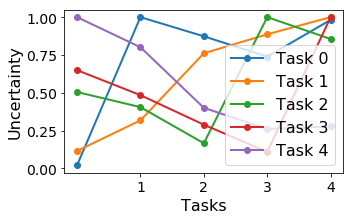

In [5]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

no_tasks=5
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for i in range(no_tasks):
    ax.plot(np.arange(len(all_uncerts_norm[i, :])), all_uncerts_norm[i, :], label='Task {}'.format(i),
               marker='o', linewidth=lw)
ax.set_xticks(range(1, len(all_uncerts_norm[i, :])))
ax.set_xlabel('Tasks', fontsize=legend_size)
ax.tick_params(labelsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend(fontsize=legend_size)
ax.set_ylabel('Uncertainty', fontsize=legend_size)
#plt.savefig("plots/not_noise_all_accs.pdf", bbox_inches='tight')
fig.show()

# Background image

In [7]:
all_uncerts_norm = all_uncerts / np.tile(np.max(all_uncerts, axis=1), (5, 1)).T

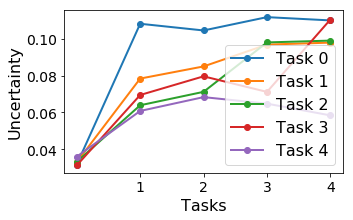

In [8]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

no_tasks=5
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for i in range(no_tasks):
    ax.plot(np.arange(len(all_uncerts[i, :])), all_uncerts[i, :], label='Task {}'.format(i),
               marker='o', linewidth=lw)
ax.set_xticks(range(1, len(all_uncerts[i, :])))
ax.set_xlabel('Tasks', fontsize=legend_size)
ax.tick_params(labelsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend(fontsize=legend_size)
ax.set_ylabel('Uncertainty', fontsize=legend_size)
#plt.savefig("plots/not_noise_all_accs.pdf", bbox_inches='tight')
fig.show()

# Random background

In [10]:
all_uncerts_norm = all_uncerts / np.tile(np.max(all_uncerts, axis=1), (5, 1)).T

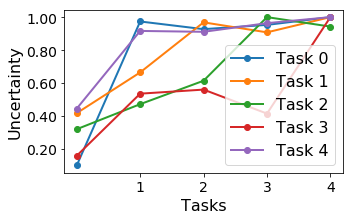

In [11]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

no_tasks=5
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for i in range(no_tasks):
    ax.plot(np.arange(len(all_uncerts_norm[i, :])), all_uncerts_norm[i, :], label='Task {}'.format(i),
               marker='o', linewidth=lw)
ax.set_xticks(range(1, len(all_uncerts_norm[i, :])))
ax.set_xlabel('Tasks', fontsize=legend_size)
ax.tick_params(labelsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend(fontsize=legend_size)
ax.set_ylabel('Uncertainty', fontsize=legend_size)
#plt.savefig("plots/not_noise_all_accs.pdf", bbox_inches='tight')
fig.show()

# Not MNIST

In [ ]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

no_tasks=5
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for i in range(no_tasks):
    ax.plot(np.arange(len(all_uncerts[i, :])), all_uncerts[i, :], label='Task {}'.format(i),
               marker='o', linewidth=lw)
ax.set_xticks(range(1, len(all_uncerts[i, :])))
ax.set_xlabel('Tasks', fontsize=legend_size)
ax.tick_params(labelsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.legend(fontsize=legend_size)
ax.set_ylabel('Uncertainty', fontsize=legend_size)
#plt.savefig("plots/not_noise_all_accs.pdf", bbox_inches='tight')
fig.show()

# 2 Layers Split MNIST

In [3]:
# split_not_mnist_res5_split_not_new.pkl
with open('results/split_mnist_res5__vanilla_layer2.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'uncerts_ibp', 'uncerts_vcl_h5', 'uncerts_vcl_h10', 'uncerts_vcl_h50', 'Z'])

In [4]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

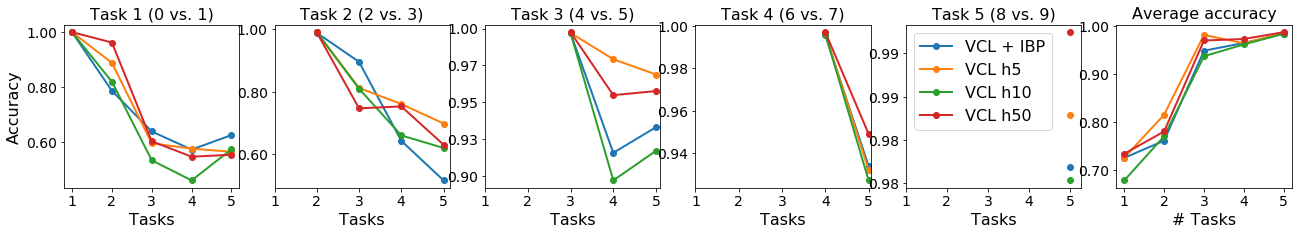

In [5]:
from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#plt.savefig("plots/split_mnist_2layer.pdf", bbox_inches='tight')
fig.show()

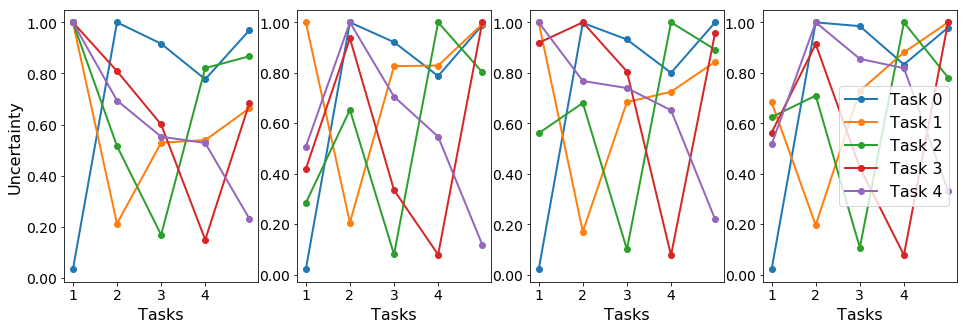

In [10]:
from visualise import plot_uncertainties
all_ibp_uncerts = d['uncerts_ibp'] # 5, 5, 5
all_vcl_h5_uncerts = d['uncerts_vcl_h5']
all_vcl_h10_uncerts = d['uncerts_vcl_h10']
all_vcl_h50_uncerts = d['uncerts_vcl_h50']
num_tasks=5
tag='split_mnist_2layer'
plot_uncertainties(num_tasks, all_ibp_uncerts, all_vcl_h5_uncerts, all_vcl_h10_uncerts, all_vcl_h50_uncerts, tag)

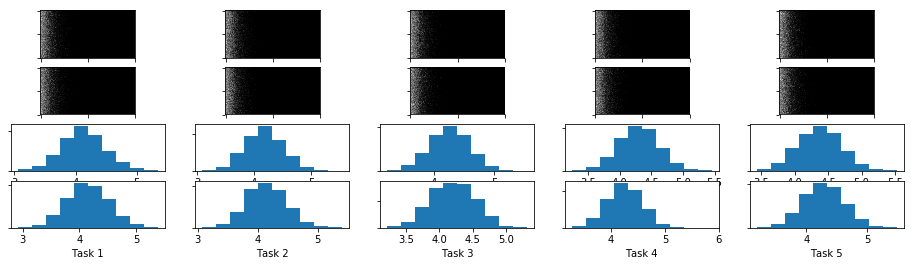

In [18]:
from visualise import plot_Zs
num_layers=2
Zs=d['Z']
dataset='vanilla_split'
plot_Zs(num_tasks, num_layers, Zs[0], dataset, tag)

# Split MNIST random background 2 layer

In [19]:
with open('results/split_mnist_res5_random_2layer.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'uncerts_ibp', 'uncerts_vcl_h5', 'uncerts_vcl_h10', 'uncerts_vcl_h50', 'Z'])

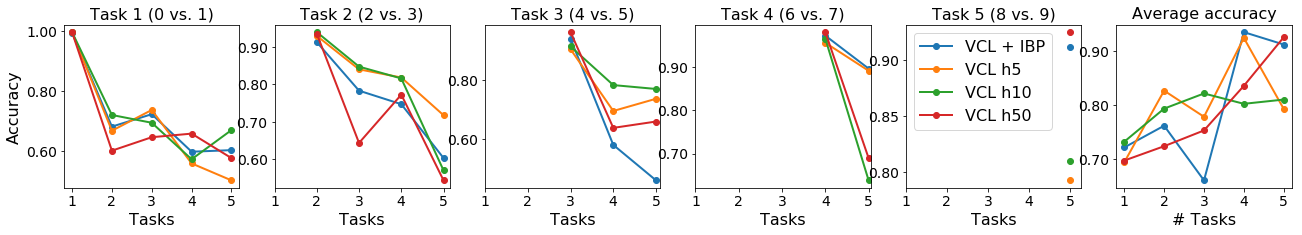

In [20]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#plt.savefig("plots/split_mnist_2layer.pdf", bbox_inches='tight')
fig.show()

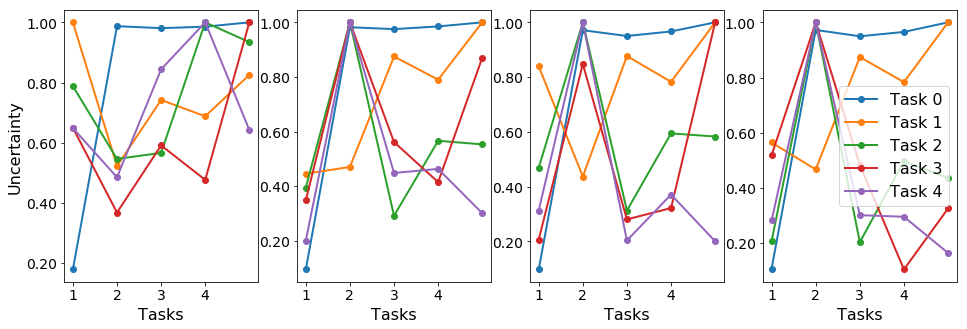

In [21]:
all_ibp_uncerts = d['uncerts_ibp'] # 5, 5, 5
all_vcl_h5_uncerts = d['uncerts_vcl_h5']
all_vcl_h10_uncerts = d['uncerts_vcl_h10']
all_vcl_h50_uncerts = d['uncerts_vcl_h50']
num_tasks=5
tag='split_mnist_random_2layer'
plot_uncertainties(num_tasks, all_ibp_uncerts, all_vcl_h5_uncerts, all_vcl_h10_uncerts, all_vcl_h50_uncerts, tag)

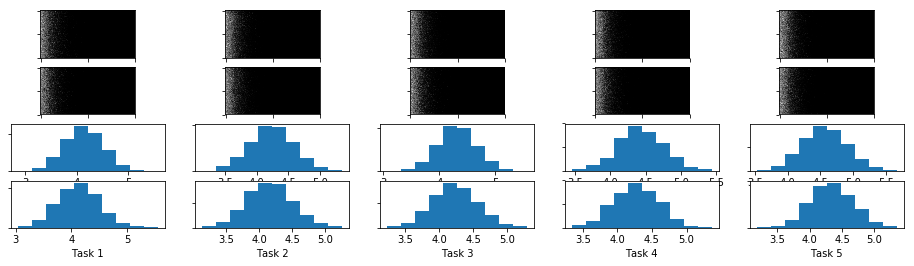

In [22]:
num_layers=2
Zs=d['Z']
dataset='split_random'
plot_Zs(num_tasks, num_layers, Zs[0], dataset, tag)

# Split MNIST random background 2 layer

In [23]:
with open('results/split_mnist_res5_background_2layer.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'uncerts_ibp', 'uncerts_vcl_h5', 'uncerts_vcl_h10', 'uncerts_vcl_h50', 'Z'])

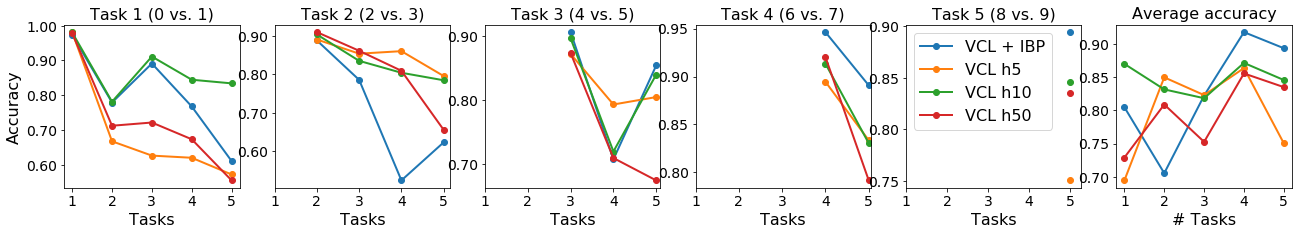

In [24]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

from matplotlib.ticker import FormatStrFormatter
lw = 2
grid_color = '0.1'
grid_lw = 0.2
title_size = 16
label_size = 22
tick_size = 14
legend_size = 16

titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o', linewidth=lw)
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o', linewidth=lw)
    ax[i].set_title(titles[i], fontsize=legend_size)
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks', fontsize=legend_size)
    ax[i].tick_params(labelsize=tick_size)
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i == 4:
        ax[i].legend(fontsize=legend_size)
    if i == 0:
        ax[i].set_ylabel('Accuracy', fontsize=legend_size)
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o', linewidth=lw)
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o', linewidth=lw)
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy', fontsize=legend_size)
ax[5].set_xlabel('# Tasks', fontsize=legend_size)
ax[5].tick_params(labelsize=tick_size)
ax[5].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#plt.savefig("plots/split_mnist_2layer.pdf", bbox_inches='tight')
fig.show()

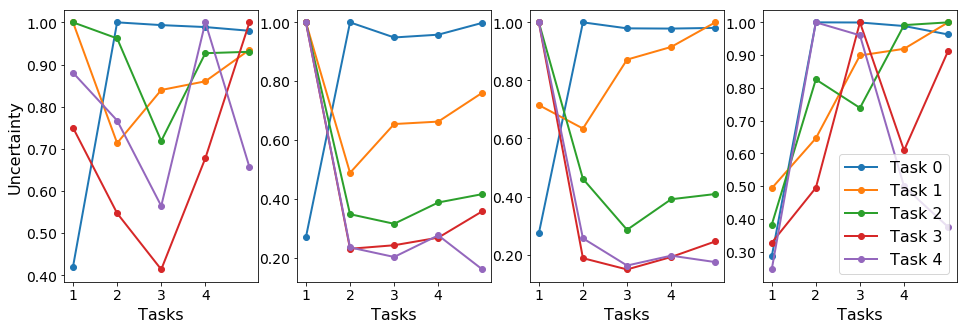

In [25]:
all_ibp_uncerts = d['uncerts_ibp'] # 5, 5, 5
all_vcl_h5_uncerts = d['uncerts_vcl_h5']
all_vcl_h10_uncerts = d['uncerts_vcl_h10']
all_vcl_h50_uncerts = d['uncerts_vcl_h50']
num_tasks=5
tag='split_mnist_background_2layer'
plot_uncertainties(num_tasks, all_ibp_uncerts, all_vcl_h5_uncerts, all_vcl_h10_uncerts, all_vcl_h50_uncerts, tag)

In [ ]:
num_layers=2
Zs=d['Z']
dataset='split_random'
plot_Zs(num_tasks, num_layers, Zs[0], dataset, tag)